In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gzip, cPickle

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa 
from statsmodels.tsa.stattools import coint

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from itertools import combinations
from tqdm import tqdm
import pickle
from datetime import datetime as dt
import math

C:\Users\Juntao\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## This step is to download and load all the ETF data

In [2]:
# pickle.dump(ETFs_GSPC, open("ETFs_GSPC_MRP_Production.p", "w"))
with gzip.open('ETFs_GSPC_MRP_Production.pkl.gz','r') as f:
    ETFs_GSPC = cPickle.load(f)

In [3]:
ETFs_GSPC.head()

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,22.098740,53.268589,56.017902,45.235744,54.408684,27.862883,NaN,14.305944,41.652599,35.166389,...,59.947933,71.388649,41.737343,14.337612,40.162682,42.196808,47.435150,8.983622,34.976913,1447.160034
2008-01-03,22.132580,52.997772,55.789246,44.755886,54.259819,27.940943,NaN,14.215148,41.288517,35.025986,...,60.058559,71.592514,41.917027,14.271438,38.910671,40.830173,46.044064,8.910232,33.672215,1447.160034
2008-01-04,21.269606,50.750046,53.393055,42.910275,51.757092,26.646067,NaN,13.811594,40.147667,33.836712,...,59.899540,71.543304,41.633671,14.278792,37.330921,39.534801,44.102032,8.794044,32.376438,1411.630005
2008-01-07,21.083485,50.280647,52.890045,42.310459,51.347736,26.297098,NaN,13.846903,40.333759,34.150543,...,60.985104,72.815964,42.158928,14.558186,37.678326,39.903980,44.398148,8.888833,32.447933,1416.180054
2008-01-08,20.525089,48.737019,51.298668,41.396889,49.868423,25.723120,NaN,13.342463,38.836933,32.705246,...,60.950520,72.717522,42.158928,14.455253,36.373859,38.453159,42.951958,8.757350,31.482798,1390.189941


In [4]:
All_ETFs = ETFs_GSPC.iloc[:, :-1]

In [5]:
All_ETFs.head(5)

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,22.098740,53.268589,56.017902,45.235744,54.408684,27.862883,NaN,14.305944,41.652599,35.166389,...,28.566296,59.947933,71.388649,41.737343,14.337612,40.162682,42.196808,47.435150,8.983622,34.976913
2008-01-03,22.132580,52.997772,55.789246,44.755886,54.259819,27.940943,NaN,14.215148,41.288517,35.025986,...,28.525572,60.058559,71.592514,41.917027,14.271438,38.910671,40.830173,46.044064,8.910232,33.672215
2008-01-04,21.269606,50.750046,53.393055,42.910275,51.757092,26.646067,NaN,13.811594,40.147667,33.836712,...,28.742760,59.899540,71.543304,41.633671,14.278792,37.330921,39.534801,44.102032,8.794044,32.376438
2008-01-07,21.083485,50.280647,52.890045,42.310459,51.347736,26.297098,NaN,13.846903,40.333759,34.150543,...,29.340000,60.985104,72.815964,42.158928,14.558186,37.678326,39.903980,44.398148,8.888833,32.447933
2008-01-08,20.525089,48.737019,51.298668,41.396889,49.868423,25.723120,NaN,13.342463,38.836933,32.705246,...,29.346796,60.950520,72.717522,42.158928,14.455253,36.373859,38.453159,42.951958,8.757350,31.482798


In [6]:
GSPC = pd.DataFrame(ETFs_GSPC.iloc[:, -1])

In [7]:
GSPC.head(5)

,Adj Close
Date,
2008-01-02,1447.160034
2008-01-03,1447.160034
2008-01-04,1411.630005
2008-01-07,1416.180054
2008-01-08,1390.189941


In [8]:
All_ETFs_log = All_ETFs.apply(np.log)
All_ETFs_log.head()

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,3.095521,3.975347,4.025671,3.811888,3.996524,3.327295,NaN,2.660675,3.729364,3.560091,...,3.352228,4.093476,4.268139,3.731396,2.662886,3.692938,3.742345,3.859364,2.195403,3.554688
2008-01-03,3.097051,3.970250,4.021581,3.801223,3.993784,3.330093,NaN,2.654308,3.720584,3.556090,...,3.350801,4.095320,4.270991,3.735692,2.658260,3.661269,3.709421,3.829599,2.187200,3.516673
2008-01-04,3.057279,3.926913,3.977681,3.759111,3.946561,3.282642,NaN,2.625508,3.692564,3.521546,...,3.358386,4.092669,4.270303,3.728909,2.658775,3.619822,3.677181,3.786506,2.174075,3.477431
2008-01-07,3.048490,3.917620,3.968215,3.745034,3.938621,3.269459,NaN,2.628062,3.697189,3.530778,...,3.378952,4.110630,4.287935,3.741446,2.678153,3.629085,3.686476,3.793198,2.184796,3.479637
2008-01-08,3.021648,3.886439,3.937665,3.723206,3.909388,3.247390,NaN,2.590952,3.659372,3.487535,...,3.379183,4.110062,4.286582,3.741446,2.671058,3.593850,3.649441,3.760082,2.169893,3.449441


## Below is to make sure all ETFs are integrated order 1

In [9]:
j = 0
for i in All_ETFs_log.columns:
    etf = All_ETFs_log[[i]].dropna(axis=0,how = 'any')
    pvalue = ADF(etf.values.flatten())[1]
    if pvalue < 0.01:
        print("original %s is stationary, cause pvalues is %s less than 0.01" % (i, pvalue))
    else:
        etf = etf.diff(1).dropna() 
        pvalue = ADF(etf.values.flatten())[1]
        if pvalue < 0.01:
            j+=1
            # print("%s is stationary in first difference , cause pvalues is %s less than 0.01" % (i, pvalue))
        else:
            print("%s is not stationary in first difference, and the p-value is %s" %(i,pvalue))


print('\n')            
print("total number of assests is %s"%(All_ETFs_log.shape[1]))
print('\n')
print ("total number of Integration of order 1 is %s"%(j))



total number of assests is 62


total number of Integration of order 1 is 62


## Drop the short ETFs, then we have 52 ETFs are left, all of them have 2539 days

In [9]:
All_ETFs_log.drop(['RYF','FTXO','PNQI', 'JHMC','PSCH','PSCI','PSCC','PSCM','XTL','REM'], axis=1, inplace=True) # 52 ETFs left

In [10]:
All_ETFs_log.head(4)

,XLK,VGT,IYW,RYT,IGM,XNTK,XLF,VFH,KBE,IYF,...,IYZ,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,3.095521,3.975347,4.025671,3.811888,3.996524,3.327295,2.660675,3.729364,3.560091,4.342348,...,3.080837,3.352228,4.093476,4.268139,3.731396,2.662886,3.692938,3.742345,3.859364,3.554688
2008-01-03,3.097051,3.970250,4.021581,3.801223,3.993784,3.330093,2.654308,3.720584,3.556090,4.333643,...,3.074992,3.350801,4.095320,4.270991,3.735692,2.658260,3.661269,3.709421,3.829599,3.516673
2008-01-04,3.057279,3.926913,3.977681,3.759111,3.946561,3.282642,2.625508,3.692564,3.521546,4.305491,...,3.052323,3.358386,4.092669,4.270303,3.728909,2.658775,3.619822,3.677181,3.786506,3.477431
2008-01-07,3.048490,3.917620,3.968215,3.745034,3.938621,3.269459,2.628062,3.697189,3.530778,4.309081,...,3.063198,3.378952,4.110630,4.287935,3.741446,2.678153,3.629085,3.686476,3.793198,3.479637


In [11]:
GSPC_log = np.log(GSPC)
GSPC_log.head()

,Adj Close
Date,
2008-01-02,7.277358
2008-01-03,7.277358
2008-01-04,7.252500
2008-01-07,7.255718
2008-01-08,7.237196


## Total we have 10 years data from 2008-01-02.
## We use 6 years to construct portfolio from 2008-01-02 -- 2013-12-31 , total 1511 trading days
## 4 years data as test set from 2014-01-02 -- 2017-12-29, total 1007 trading days

In [12]:
GSPC_log_train = GSPC_log.loc["2008-01": "2013-12-31"].copy()
GSPC_log_test = GSPC_log.loc["2014-01-01": "2017-12-31"].copy()
All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()
All_ETFs_log_test = All_ETFs_log.loc["2014-01-01": "2017-12-31"].copy()

# Let's run the regression on  all 52 ETFs, to see the result


In [13]:
LR_all = LinearRegression()
LR_all.fit(All_ETFs_log_train,GSPC_log_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
print 'The Coefficients of 52 ETFs are \n', LR_all.coef_

The Coefficients of 52 ETFs are 
[[  1.88621051e-01  -4.41512756e-01   3.76413693e-01   5.39534076e-03
    4.95932629e-02  -9.46907364e-03  -1.01730606e-02  -1.47308732e-02
   -2.27192827e-02   2.61102428e-01  -4.25835900e-02  -1.05058472e-01
    2.10798329e-01   3.24538952e-03   1.95468794e-02   7.12751679e-03
   -4.48452505e-02  -1.26381200e-02  -1.50742936e-02   2.34090273e-01
   -3.34255639e-02   2.91080043e-02   1.38223917e-02   1.35543523e-01
    1.63784917e-03   1.02627806e-01  -1.36214819e-01   1.49317810e-01
    2.01808039e-04  -1.55453644e-02   2.15319029e-02  -1.24940704e-01
    1.97536935e-01   3.66733468e-03  -1.47650687e-02   1.17720983e-01
   -1.74303562e-01   5.60481258e-02  -5.49085717e-02   2.85103704e-02
   -3.59774147e-02   1.03052249e-02   4.32747389e-02   4.98992186e-02
   -1.16989028e-02   8.43234211e-02  -8.89311566e-02   1.12942131e-02
   -3.29887975e-02  -2.36655819e-02  -1.95958591e-03   4.21608259e-02]]


In [15]:
print 'the R-Square of this LR model on all 52 ETF is %.4f%%'%(LR_all.score(All_ETFs_log_train,GSPC_log_train)*100)

the R-Square of this LR model on all 52 ETF is 99.9902%


In [16]:
print("Mean squared error: %.6f"
      % mean_squared_error(GSPC_log_train, LR_all.predict(All_ETFs_log_train)))

Mean squared error: 0.000004


In [17]:
LR_all_residual = GSPC_log_train - LR_all.predict(All_ETFs_log_train)
ADF(LR_all_residual.values.flatten())

(-7.4600970762920369,
 5.3822431216425832e-11,
 24L,
 1486L,
 {'1%': -3.4347582315402434,
  '10%': -2.5678065345286378,
  '5%': -2.863486949792871},
 -14902.416290175308)

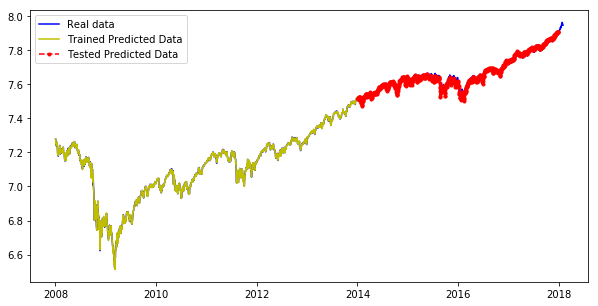

In [18]:
plt.figure(figsize=(10,5))
plt.plot(GSPC_log.index,GSPC_log, 'b-', label='Real data' )
plt.plot(All_ETFs_log_train.index,LR_all.predict(All_ETFs_log_train).flatten(), 'y-', label='Trained Predicted Data' )
plt.plot(All_ETFs_log_test.index,LR_all.predict(All_ETFs_log_test).flatten(), 'r--.',label='Tested Predicted Data')
plt.legend(loc='upper left')
plt.show()

# Let's run LASSO regression on all 53 ETFs, and see the result

In [31]:
np.arange(0.00001, 0.011, 0.0001)

array([  1.00000000e-05,   1.10000000e-04,   2.10000000e-04,
         3.10000000e-04,   4.10000000e-04,   5.10000000e-04,
         6.10000000e-04,   7.10000000e-04,   8.10000000e-04,
         9.10000000e-04,   1.01000000e-03,   1.11000000e-03,
         1.21000000e-03,   1.31000000e-03,   1.41000000e-03,
         1.51000000e-03,   1.61000000e-03,   1.71000000e-03,
         1.81000000e-03,   1.91000000e-03,   2.01000000e-03,
         2.11000000e-03,   2.21000000e-03,   2.31000000e-03,
         2.41000000e-03,   2.51000000e-03,   2.61000000e-03,
         2.71000000e-03,   2.81000000e-03,   2.91000000e-03,
         3.01000000e-03,   3.11000000e-03,   3.21000000e-03,
         3.31000000e-03,   3.41000000e-03,   3.51000000e-03,
         3.61000000e-03,   3.71000000e-03,   3.81000000e-03,
         3.91000000e-03,   4.01000000e-03,   4.11000000e-03,
         4.21000000e-03,   4.31000000e-03,   4.41000000e-03,
         4.51000000e-03,   4.61000000e-03,   4.71000000e-03,
         4.81000000e-03,

In [20]:
len( np.arange(0.00001, 0.011, 0.0001))

110

In [146]:
# j = 0
# m = 0
# for i in np.arange(0.000001, 0.011, 0.00001):
#     m+=1
#     LR_lasso = Lasso(alpha=i, fit_intercept=True,normalize=None)
#     LR_lasso.fit(All_ETFs_log_train,GSPC_log_train)
#     LR_lasso_residual = GSPC_log_train.values.flatten() - LR_lasso.predict(All_ETFs_log_train)
#     if check_for_stationarity_no_print(LR_lasso_residual.flatten(),cutoff=0.05):
#         j+= 1
#         print '\nthe alpha in LASSO is %s and the P-value for ADF is %s'%(i, ADF(LR_lasso_residual.flatten())[1])
#         print 'with in all coefficients, there are %s ETFs are positive'%(sum(LR_lasso.coef_>0))
#         print 'with in all coefficients, there are %s ETFs are negative'%(sum(LR_lasso.coef_<0))

# print '\n\ntotal %s LR models are stationary'%(j)
# print 'total we tested %s models'%(m)       

In [311]:
LR_lasso_1 = Lasso(alpha=0.000131 , fit_intercept=True,normalize=None)
LR_lasso_1.fit(All_ETFs_log_train,GSPC_log_train)

Lasso(alpha=0.000131, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=None, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
sum(LR_lasso_1.coef_<0)

0

In [21]:
print sum(LR_lasso_1.coef_ > 0 )
print sum(LR_lasso_1.coef_ < 0 )
print sum(LR_lasso_1.coef_ == 0 )

12
0
40


In [312]:
np.where(LR_lasso_1.coef_)

(array([ 0,  6,  9, 12, 16, 17, 21, 22, 25, 27, 43, 51], dtype=int64),)

In [313]:
np.where(LR_lasso_1.coef_)
All_ETFs_log_train.iloc[:,[ 0,  6,  9, 12, 16, 17, 21, 22, 25, 27, 43, 51]].head()

,XLK,XLF,IYF,IYC,XLV,IBB,XLI,VIS,XLE,IYE,XLU,USRT
Date,,,,,,,,,,,,
2008-01-02,3.095521,2.660675,4.342348,3.990660,3.372757,3.272472,3.430769,4.095256,4.157497,3.633426,3.352228,3.554688
2008-01-03,3.097051,2.654308,4.333643,3.977545,3.378749,3.277166,3.431548,4.097615,4.169252,3.639774,3.350801,3.516673
2008-01-04,3.057279,2.625508,4.305491,3.950958,3.368454,3.262143,3.410837,4.070632,4.132018,3.613619,3.358386,3.477431
2008-01-07,3.048490,2.628062,4.309081,3.956605,3.388093,3.276056,3.398308,4.062910,4.128139,3.600468,3.378952,3.479637
2008-01-08,3.021648,2.590952,4.274322,3.935566,3.396233,3.278397,3.375793,4.035699,4.110498,3.586913,3.379183,3.449441


In [24]:
LR_lasso_1.score(All_ETFs_log_train,GSPC_log_train)

0.99943850105558096

In [28]:
LR_lasso_1_residual = GSPC_log_train.values.flatten() - LR_lasso_1.predict(All_ETFs_log_train)
check_for_stationarity(LR_lasso_1_residual.flatten(),cutoff=0.05)

p-value = 6.60098673307e-05 The series  is likely stationary.


In [29]:
LR_lasso_1.intercept_

array([ 4.12154721])

In [30]:
LR_lasso_1_residual

array([ 0.00885257,  0.0079815 ,  0.00653091, ...,  0.00563458,
        0.00682113,  0.00626687])

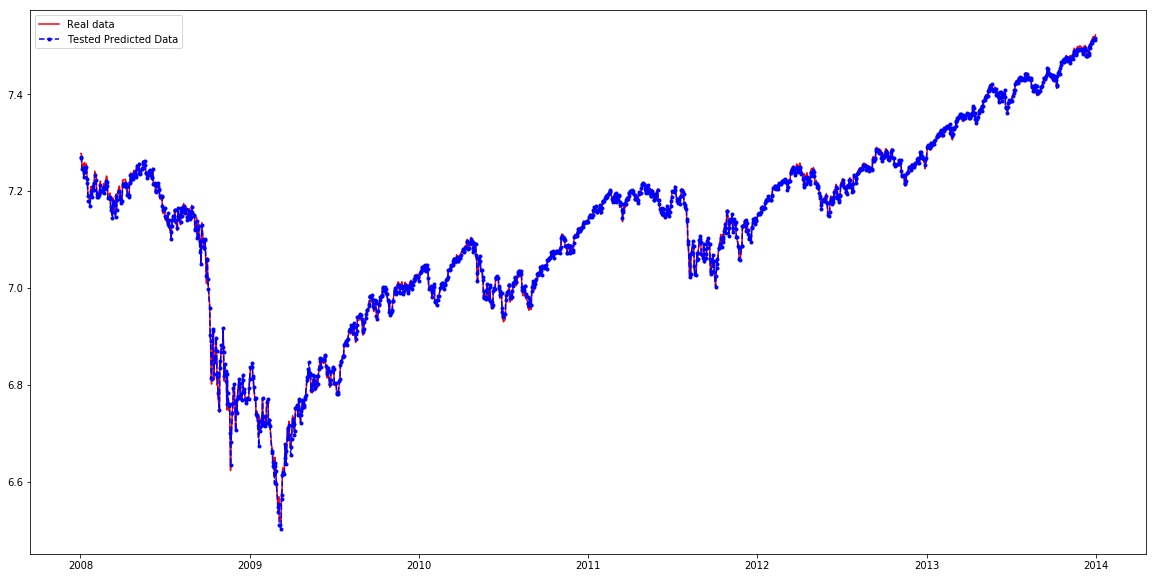

In [74]:
plt.figure(figsize=(20,10))
plt.plot(GSPC_log_train.index,GSPC_log_train, 'r-', label='Real data' )
plt.plot(All_ETFs_log_train.index,LR_lasso_1.predict(All_ETFs_log_train), 'b--.',label='Tested Predicted Data')
plt.legend(loc='upper left')
plt.show()

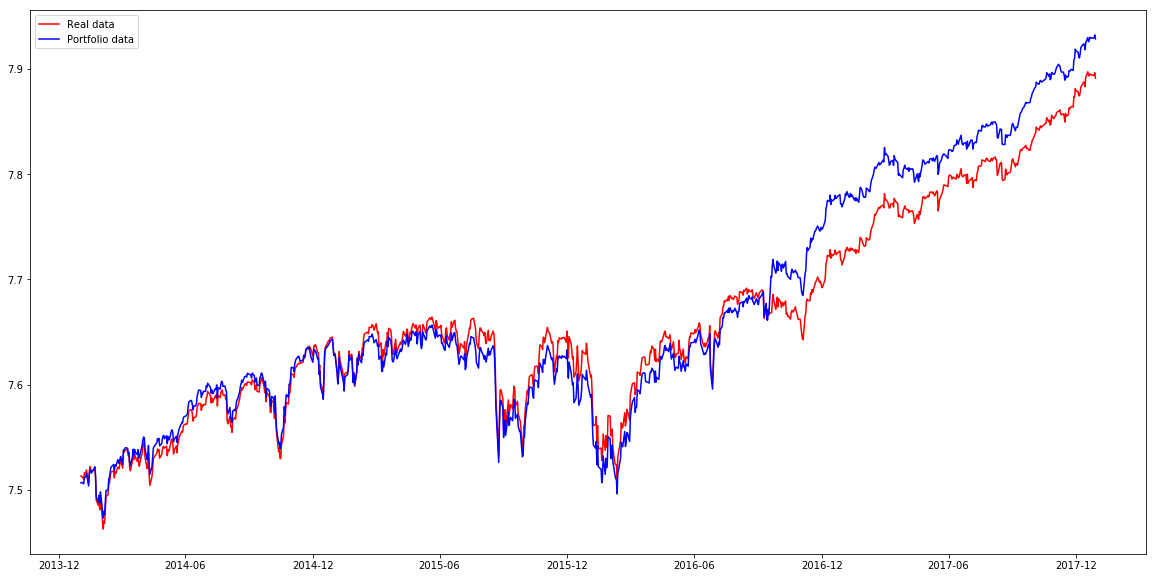

In [75]:
plt.figure(figsize=(20,10))
plt.plot(GSPC_log_test.index,GSPC_log_test, 'r-', label='Real data' )
plt.plot(All_ETFs_log_test.index,LR_lasso_1.predict(All_ETFs_log_test), 'b-', label='Portfolio data' )
plt.legend(loc='upper left')
plt.show()

## Let's normalized the coefficients, and see plot the performance of this portfolio

In [80]:
coefficients= LR_lasso_1.coef_.copy()
LR_lasso_coefficient = pd.DataFrame(data = coefficients,columns = ['Coefficients'])

In [83]:
LR_lasso_coefficient['Coefficients'] = LR_lasso_coefficient/LR_lasso_coefficient.sum()

In [84]:
Portfolio_test = All_ETFs_log_test.dot(LR_lasso_coefficient.values)
Portfolio_test.columns = ['Portfolio Log Value Test']

In [85]:
Portfolio_test.head()

,Portfolio Log Value Test
Date,
2014-01-02,3.730058
2014-01-03,3.730411
2014-01-06,3.728929
2014-01-07,3.735469
2014-01-08,3.735700


In [38]:
normalized_portfolio_residual = GSPC_log_test.iloc[:,0]-Portfolio_test.values.flatten()

In [39]:
ADF(normalized_portfolio_residual.values.flatten())

(-0.37704912504195309,
 0.91386080391633417,
 0L,
 1006L,
 {'1%': -3.436866962597422,
  '10%': -2.5683020002450507,
  '5%': -2.8644172846037028},
 -9582.0761302840747)

## this the log price, for S&P500, and regular coefficient portfolios, and normalized coefficients portfolio

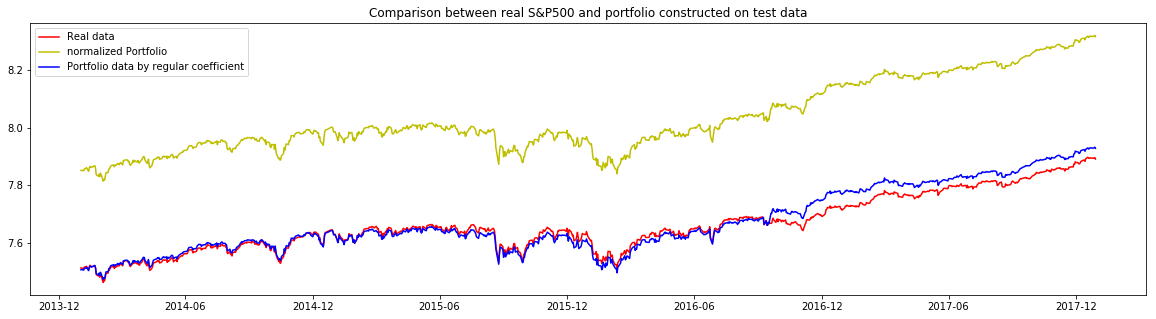

In [88]:
intercept = LR_lasso_1.intercept_.flatten()
plt.figure(figsize=(20,5))
plt.plot(GSPC_log_test.index,GSPC_log_test['Adj Close'], 'r-', label='Real data' )
plt.plot(Portfolio_test.index,Portfolio_test.values+intercept, 'y-', label='normalized Portfolio' )
plt.plot(All_ETFs_log_test.index,LR_lasso_1.predict(All_ETFs_log_test), 'b-', label='Portfolio data by regular coefficient' )
plt.legend(loc='upper left')
plt.title('Comparison between real S&P500 and portfolio constructed on test data')
plt.show()

In [89]:
GSPC_log_test = GSPC_log.loc["2014-01-01": "2017-12-31"].copy()
GSPC_log_test['Regular Index'] = GSPC.loc["2014-01-01": "2017-12-31"].copy()

In [90]:
GSPC_log_test['Daily_Return'] = GSPC_log_test['Adj Close'].diff()
GSPC_log_test['Daily_Return'][0] = 0
GSPC_log_test['Cumsum Daily_Return'] = GSPC_log_test['Daily_Return'].cumsum()

In [91]:
#GSPC_log_test.head(10)

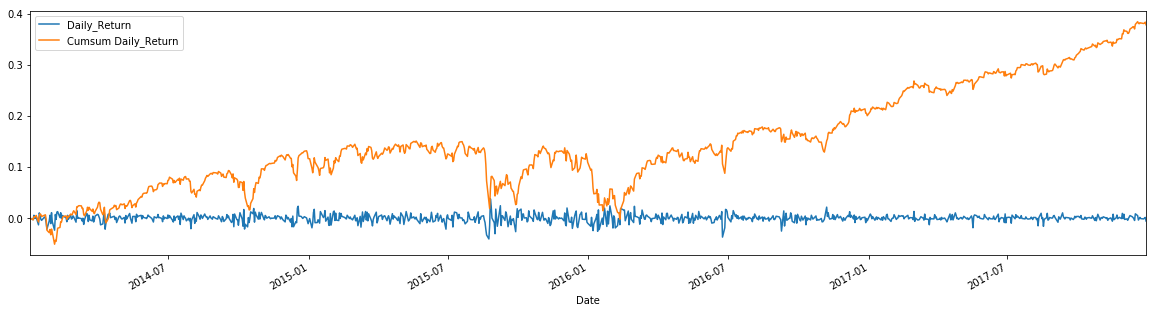

In [92]:
GSPC_log_test['Daily_Return'].plot(figsize=(20,5))
GSPC_log_test['Cumsum Daily_Return'].plot(figsize=(20,5))
plt.legend(loc='upper left')
plt.show()

In [93]:
Portfolio_test.head()

,Portfolio Log Value Test
Date,
2014-01-02,3.730058
2014-01-03,3.730411
2014-01-06,3.728929
2014-01-07,3.735469
2014-01-08,3.735700


In [94]:
Portfolio_test['Daily_Return'] = Portfolio_test.iloc[:,0].diff()
Portfolio_test['Daily_Return'][0] = 0
Portfolio_test['Cumsum Daily_Return'] = Portfolio_test['Daily_Return'].cumsum()  

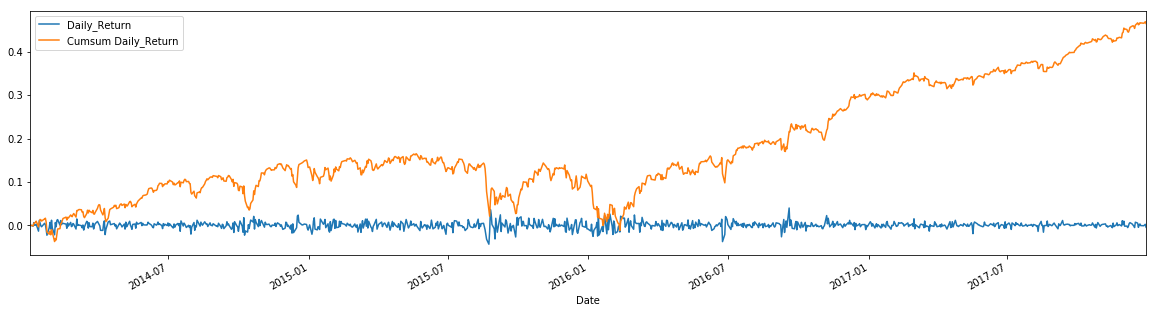

In [95]:
Portfolio_test['Daily_Return'].plot(figsize=(20,5))
Portfolio_test['Cumsum Daily_Return'].plot(figsize=(20,5))
plt.legend(loc='upper left')
plt.show()

## Out of Sample Tracking Error Analysis
Tracking error is the difference between the portfolio return and underlying index return <br\><br\>
$ T.E. = R_{p}-R_{I}$ 

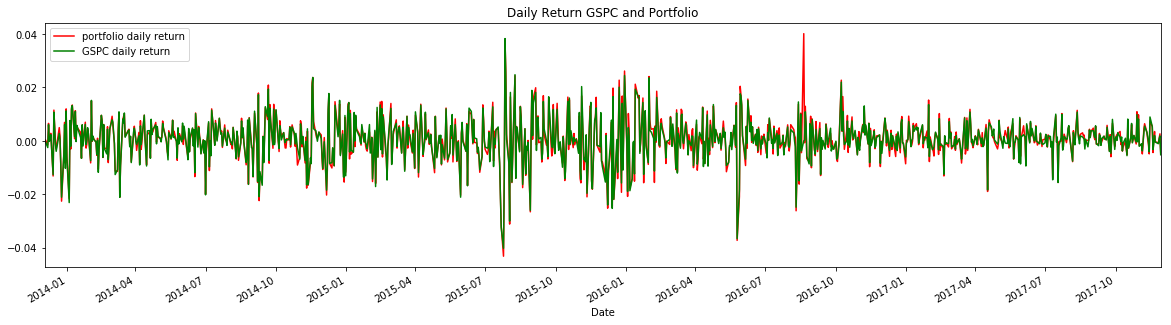

In [223]:
Portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'portfolio daily return',style='r-')
GSPC_log_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'GSPC daily return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = '3M'))
plt.title('Daily Return GSPC and Portfolio')
plt.show()

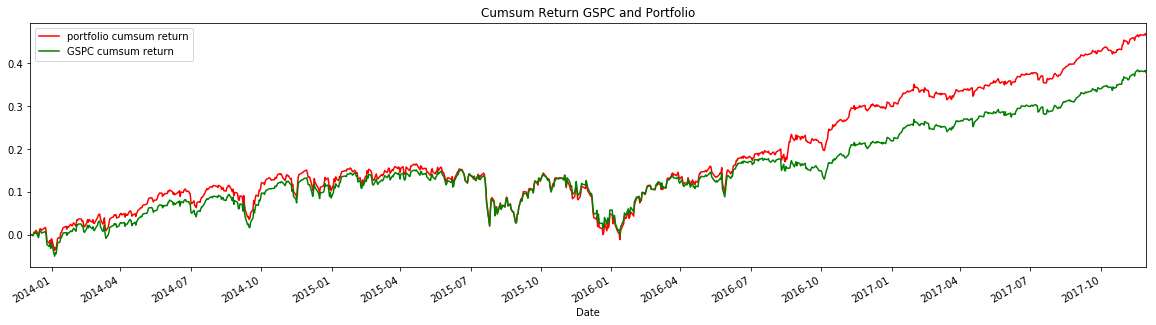

In [222]:
Portfolio_test['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'portfolio cumsum return',style='r-')
GSPC_log_test['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'GSPC cumsum return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = '3M'))
plt.title('Cumsum Return GSPC and Portfolio')
plt.show()

#### compare average return and volatility

In [228]:
GSPC_log_test['Daily_Return'].describe()

count    1007.000000
mean        0.000375
std         0.007620
min        -0.040211
25%        -0.002719
50%         0.000367
75%         0.004368
max         0.038291
Name: Daily_Return, dtype: float64

In [264]:
print('S&P 500 average daily return is %.3f%%')%(GSPC_log_test['Daily_Return'].mean() *100)
print('\nS&P 500 cumulative return is %.3f%%')%(GSPC_log_test['Cumsum Daily_Return'][-1]*100)
print('\nS&P 500 daily volatility is %.3f%%')%(GSPC_log_test['Daily_Return'].std() *100)
print('\nS&P 500 annual volatility is %.3f%%')%(GSPC_log_test['Daily_Return'].std()*(np.sqrt(252)) *100)

S&P 500 average daily return is 0.038%

S&P 500 cumulative return is 37.803%

S&P 500 daily volatility is 0.762%

S&P 500 annual volatility is 12.096%


In [265]:
print('Portfolio average daily return is %.3f%%')%(Portfolio_test['Daily_Return'].mean() *100)
print('\nPortfolio cumulative return is %.3f%%')%(Portfolio_test['Cumsum Daily_Return'][-1]*100)
print('\nPortfolio daily volatility is %.3f%%')%(Portfolio_test['Daily_Return'].std() *100)
print('\nPortfolio annual volatility is %.3f%%')%(Portfolio_test['Daily_Return'].std()*(np.sqrt(252)) *100)

Portfolio average daily return is 0.046%

Portfolio cumulative return is 46.473%

Portfolio daily volatility is 0.805%

Portfolio annual volatility is 12.776%


#### Correlation between portfolio return and index return

In [158]:
print('Correlation coefficient between portfolio and underlying index is %.6f')%(np.corrcoef(GSPC_log_test['Daily_Return'].values.flatten(),Portfolio_test['Daily_Return'].values.flatten())[0,1])

Correlation coefficient between portfolio and underlying index is 0.973889


In [164]:
Track_error = Portfolio_test['Daily_Return'] - GSPC_log_test['Daily_Return']

#### Tracking Error Variance

In [166]:
print('Tracking Error Variance is %.6f') %(np.var(Track_error)) 

Tracking Error Variance is 0.000003


In [165]:
np.sum(Track_error**2)

0.0034135282287830675

#### Information Ratio for Portfolio
\begin{equation}
IR = \frac{E(R_{p}-R_{I})}{\sqrt{Var(R_{p}-R_{I})}} 
\end{equation} 

In [170]:
print('Information ratio of the portfolio is %.3f')%(np.mean(Track_error)/np.std(Track_error))

Information ratio of the portfolio is 0.047


# Rebalance Interval
### quarterly
### semi-annually
### annually

# Enhanced Index Tracking 

In [432]:
GSPC_log_train_5per = GSPC_log_train.copy()*1.05

In [433]:
GSPC_log_train['Daily_Return'] = GSPC_log_train['Adj Close'].diff()
GSPC_log_train['Daily_Return'][0] = 0
GSPC_log_train['Cumsum Daily_Return'] = GSPC_log_train['Daily_Return'].cumsum()

In [434]:
GSPC_log_train_5per['Daily_Return'] = GSPC_log_train_5per['Adj Close'].diff()
GSPC_log_train_5per['Daily_Return'][0] = 0
GSPC_log_train_5per['Cumsum Daily_Return'] = GSPC_log_train_5per['Daily_Return'].cumsum()

In [437]:
GSPC_log_train_5per.head()

,Adj Close,Daily_Return,Cumsum Daily_Return
Date,,,
2008-01-02,7.641226,0.000000,0.000000
2008-01-03,7.641226,0.000000,0.000000
2008-01-04,7.615125,-0.026101,-0.026101
2008-01-07,7.618504,0.003379,-0.022722
2008-01-08,7.599055,-0.019449,-0.042171


In [438]:
GSPC_log_train.head()

,Adj Close,Daily_Return,Cumsum Daily_Return
Date,,,
2008-01-02,7.277358,0.000000,0.000000
2008-01-03,7.277358,0.000000,0.000000
2008-01-04,7.252500,-0.024858,-0.024858
2008-01-07,7.255718,0.003218,-0.021640
2008-01-08,7.237196,-0.018523,-0.040163


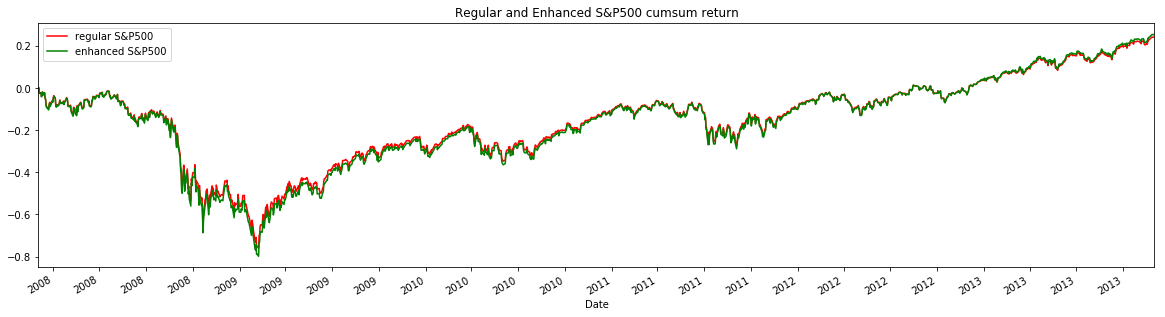

In [440]:
GSPC_log_train['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'regular S&P500',style='r-')
GSPC_log_train_5per['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'enhanced S&P500',style='g-')
#Portfolio_test['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'Regular Portfolio Daily_Return',style='b--')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2008-1-01', end='2014-01-01', freq = '3M'))
plt.title('Regular and Enhanced S&P500 cumsum return')
plt.show()

In [338]:

LR_lasso_EIT = Lasso(alpha=0.000131 , fit_intercept=True,normalize=None)
LR_lasso_EIT.fit(All_ETFs_log_train,GSPC_log_train_5per)

Lasso(alpha=0.000131, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=None, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [288]:
LR_lasso_EIT.coef_ 

array([ 0.19887633,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.13297373,  0.        ,  0.        ,  0.08418567,
        0.        ,  0.        ,  0.00547942,  0.        ,  0.        ,
        0.        ,  0.11182353,  0.01548223,  0.        ,  0.        ,
        0.        ,  0.1058703 ,  0.05327663,  0.        ,  0.        ,
        0.14441671,  0.        ,  0.00788287,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.08599112,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.0081984 ])

In [307]:
np.where(LR_lasso_EIT.coef_>0)

(array([ 0,  6,  9, 12, 16, 17, 21, 22, 25, 27, 43, 51], dtype=int64),)

In [314]:
np.where(LR_lasso_1.coef_)

(array([ 0,  6,  9, 12, 16, 17, 21, 22, 25, 27, 43, 51], dtype=int64),)

In [315]:
All_ETFs_log_train.iloc[:,[ 0,  6,  9, 12, 16, 17, 21, 22, 25, 27, 43, 51]].head()

,XLK,XLF,IYF,IYC,XLV,IBB,XLI,VIS,XLE,IYE,XLU,USRT
Date,,,,,,,,,,,,
2008-01-02,3.095521,2.660675,4.342348,3.990660,3.372757,3.272472,3.430769,4.095256,4.157497,3.633426,3.352228,3.554688
2008-01-03,3.097051,2.654308,4.333643,3.977545,3.378749,3.277166,3.431548,4.097615,4.169252,3.639774,3.350801,3.516673
2008-01-04,3.057279,2.625508,4.305491,3.950958,3.368454,3.262143,3.410837,4.070632,4.132018,3.613619,3.358386,3.477431
2008-01-07,3.048490,2.628062,4.309081,3.956605,3.388093,3.276056,3.398308,4.062910,4.128139,3.600468,3.378952,3.479637
2008-01-08,3.021648,2.590952,4.274322,3.935566,3.396233,3.278397,3.375793,4.035699,4.110498,3.586913,3.379183,3.449441


In [318]:
LR_lasso_EIT_residual = GSPC_log_train_5per.values.flatten() - LR_lasso_EIT.predict(All_ETFs_log_train)
check_for_stationarity(LR_lasso_EIT_residual.flatten(),cutoff=0.05)

p-value = 6.34694342529e-05 The series  is likely stationary.


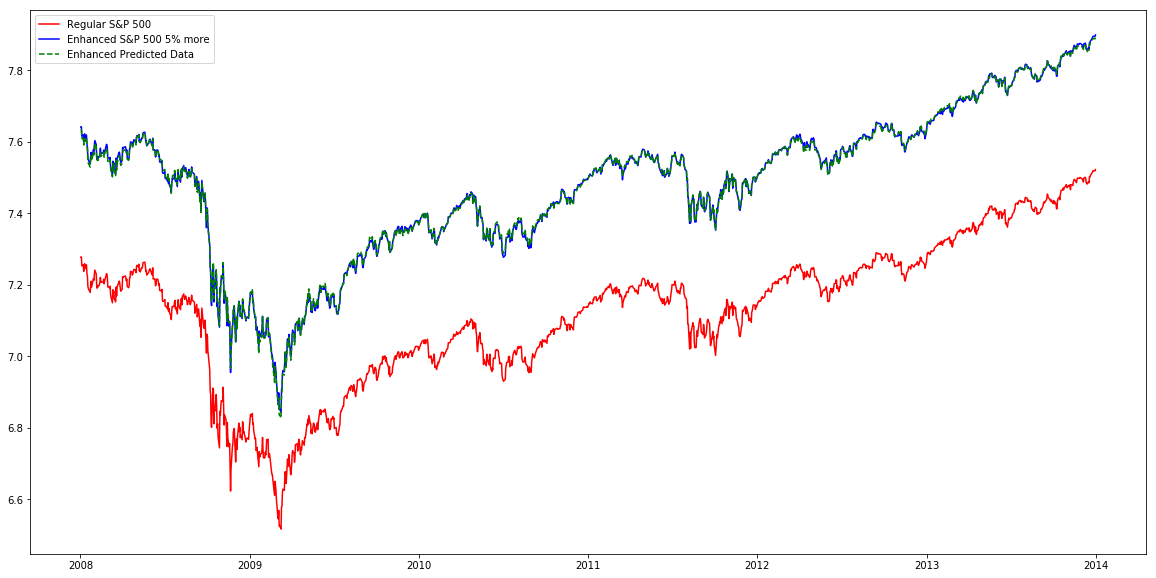

In [336]:
plt.figure(figsize=(20,10))
plt.plot(GSPC_log_train.index,GSPC_log_train, 'r-', label='Regular S&P 500' )
plt.plot(GSPC_log_train_5per.index,GSPC_log_train_5per, 'b-', label='Enhanced S&P 500 5% more' )
plt.plot(All_ETFs_log_train.index,LR_lasso_EIT.predict(All_ETFs_log_train), 'g--',label='Enhanced Predicted Data')
plt.legend(loc='upper left')
plt.show()

In [328]:
GSPC_log_train.diff().cumsum().tail()

,Adj Close
Date,
2013-12-24,0.236525
2013-12-26,0.241260
2013-12-27,0.240923
2013-12-30,0.240744
2013-12-31,0.244696


In [329]:
GSPC_log_train_5per.diff().cumsum().tail()

,Adj Close
Date,
2013-12-24,0.248352
2013-12-26,0.253323
2013-12-27,0.252969
2013-12-30,0.252781
2013-12-31,0.256930


## For Enhanced Index Tracking, Let's normalized the coefficients, and see plot the performance of this portfolio

In [337]:
LR_lasso_EIT.coef_

array([ 0.19887633,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.13297373,  0.        ,  0.        ,  0.08418567,
        0.        ,  0.        ,  0.00547942,  0.        ,  0.        ,
        0.        ,  0.11182353,  0.01548223,  0.        ,  0.        ,
        0.        ,  0.1058703 ,  0.05327663,  0.        ,  0.        ,
        0.14441671,  0.        ,  0.00788287,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.08599112,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.0081984 ])

In [339]:
EIT_coefficients = LR_lasso_EIT.coef_.copy()
LR_EIT_coefficient = pd.DataFrame(data = EIT_coefficients,columns = ['Coefficients'])
LR_EIT_coefficient['Coefficients'] = LR_EIT_coefficient/LR_EIT_coefficient.sum()

In [352]:
EIT_Portfolio_test = All_ETFs_log_test.dot(LR_EIT_coefficient.values)
EIT_Portfolio_test.columns = ['EIT Log Value Test']

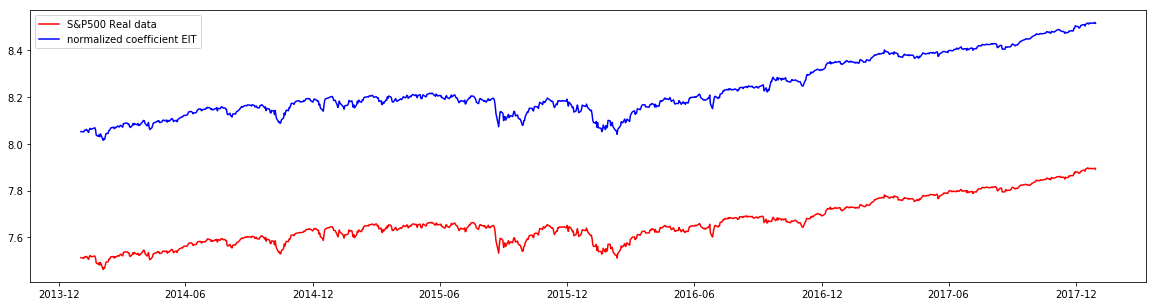

In [362]:
plt.figure(figsize=(20,5))
plt.plot(GSPC_log_test.index,GSPC_log_test['Adj Close'], 'r-', label='S&P500 Real data' )
plt.plot(GSPC_log_test.index,EIT_Portfolio_test+LR_lasso_EIT.intercept_, 'b-', label='normalized coefficient EIT' )
plt.legend(loc='upper left')
plt.show()

In [364]:
GSPC_log_test.head()

,Adj Close,Regular Index,Daily_Return,Cumsum Daily_Return
Date,,,,
2014-01-02,7.513153,1831.979980,0.000000,0.000000
2014-01-03,7.512820,1831.369995,-0.000333,-0.000333
2014-01-06,7.510305,1826.770020,-0.002515,-0.002848
2014-01-07,7.516368,1837.880005,0.006063,0.003215
2014-01-08,7.516156,1837.489990,-0.000212,0.003003


In [371]:
EIT_Portfolio_test['Daily_Return'] = EIT_Portfolio_test['EIT Log Value Test'].diff()
EIT_Portfolio_test['Daily_Return'][0]=0
EIT_Portfolio_test['Cumsum Daily_Return'] = EIT_Portfolio_test['Daily_Return'].cumsum()

In [372]:
EIT_Portfolio_test.head()

,EIT Log Value Test,Daily_Return,Cumsum Daily_Return
Date,,,
2014-01-02,3.732416,0.000000,0.000000
2014-01-03,3.732768,0.000353,0.000353
2014-01-06,3.731299,-0.001470,-0.001117
2014-01-07,3.737842,0.006543,0.005426
2014-01-08,3.738066,0.000224,0.005650


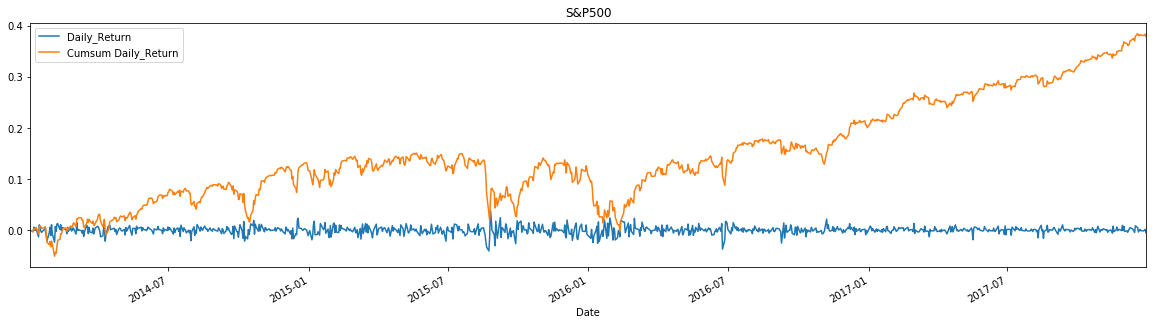

In [373]:
GSPC_log_test['Daily_Return'].plot(figsize=(20,5))
GSPC_log_test['Cumsum Daily_Return'].plot(figsize=(20,5))
plt.legend(loc='upper left')
plt.title('S&P500')
plt.show()

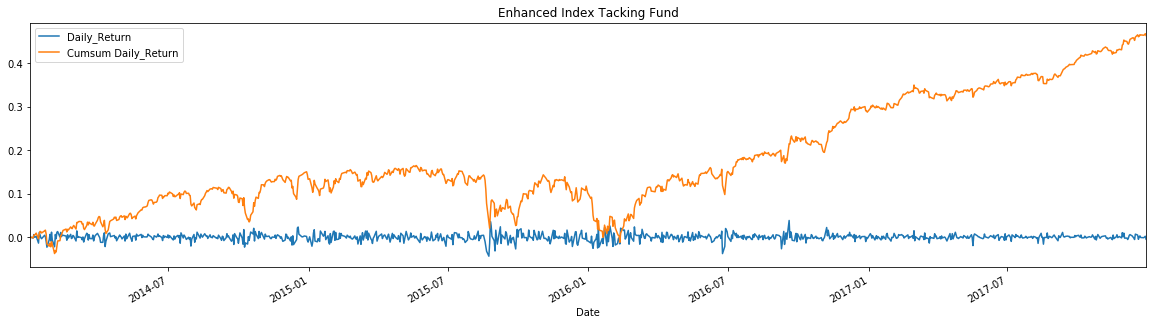

In [375]:
EIT_Portfolio_test['Daily_Return'].plot(figsize=(20,5))
EIT_Portfolio_test['Cumsum Daily_Return'].plot(figsize=(20,5))
plt.legend(loc='upper left')
plt.title('Enhanced Index Tacking Fund')
plt.show()

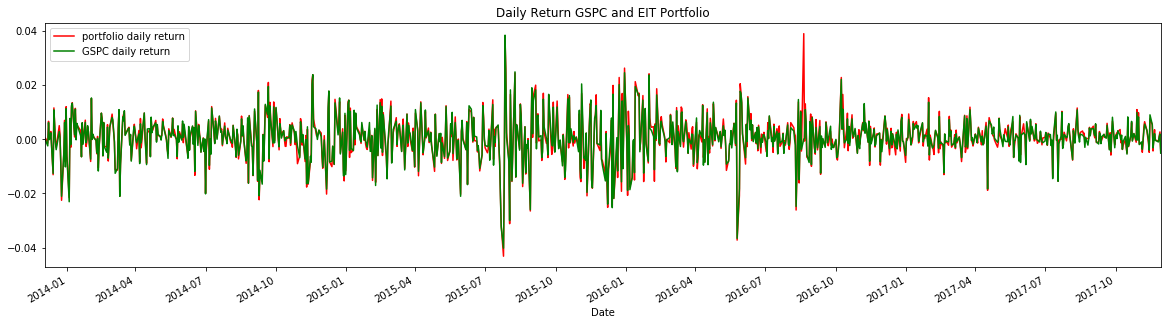

In [377]:
EIT_Portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'portfolio daily return',style='r-')
GSPC_log_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'GSPC daily return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = '3M'))
plt.title('Daily Return GSPC and EIT Portfolio')
plt.show()

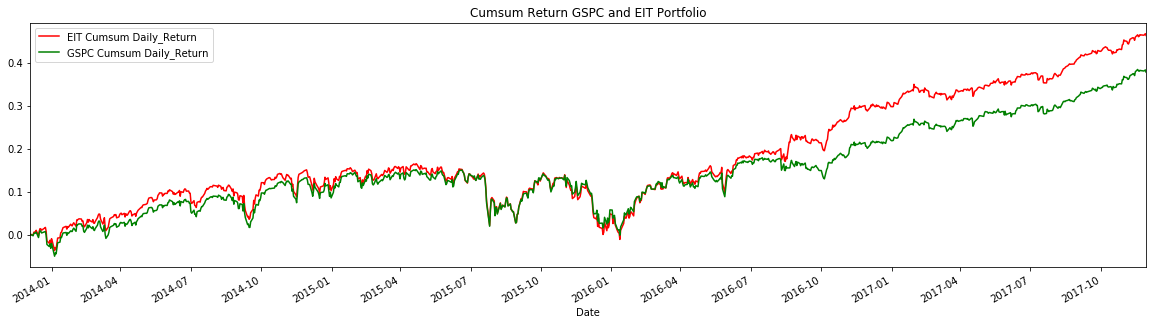

In [412]:
EIT_Portfolio_test['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'EIT Cumsum Daily_Return',style='r-')
GSPC_log_test['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'GSPC Cumsum Daily_Return',style='g-')
#Portfolio_test['Cumsum Daily_Return'].plot(kind='line',figsize=(20,5),label = 'Regular Portfolio Daily_Return',style='b--')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = '3M'))
plt.title('Cumsum Return GSPC and EIT Portfolio')
plt.show()

In [410]:
EIT_Portfolio_test.tail()

,EIT Log Value Test,Daily_Return,Cumsum Daily_Return
Date,,,
2017-12-22,4.197085,-0.000350,0.464669
2017-12-26,4.196340,-0.000746,0.463924
2017-12-27,4.197320,0.000980,0.464904
2017-12-28,4.199953,0.002634,0.467538
2017-12-29,4.195798,-0.004155,0.463383


#### compare average return and volatility

In [413]:
GSPC_log_test['Daily_Return'].describe()

count    1007.000000
mean        0.000375
std         0.007620
min        -0.040211
25%        -0.002719
50%         0.000367
75%         0.004368
max         0.038291
Name: Daily_Return, dtype: float64

In [414]:
print('S&P 500 average daily return is %.3f%%')%(GSPC_log_test['Daily_Return'].mean() *100)
print('\nS&P 500 cumulative return is %.3f%%')%(GSPC_log_test['Cumsum Daily_Return'][-1]*100)
print('\nS&P 500 daily volatility is %.3f%%')%(GSPC_log_test['Daily_Return'].std() *100)
print('\nS&P 500 annual volatility is %.3f%%')%(GSPC_log_test['Daily_Return'].std()*(np.sqrt(252)) *100)

S&P 500 average daily return is 0.038%

S&P 500 cumulative return is 37.803%

S&P 500 daily volatility is 0.762%

S&P 500 annual volatility is 12.096%


In [415]:
print('EIT_Portfolio average daily return is %.3f%%')%(EIT_Portfolio_test['Daily_Return'].mean() *100)
print('\nEIT_Portfolio cumulative return is %.3f%%')%(EIT_Portfolio_test['Cumsum Daily_Return'][-1]*100)
print('\nEIT_Portfolio daily volatility is %.3f%%')%(EIT_Portfolio_test['Daily_Return'].std() *100)
print('\nEIT_Portfolio annual volatility is %.3f%%')%(EIT_Portfolio_test['Daily_Return'].std()*(np.sqrt(252)) *100)

EIT_Portfolio average daily return is 0.046%

EIT_Portfolio cumulative return is 46.338%

EIT_Portfolio daily volatility is 0.804%

EIT_Portfolio annual volatility is 12.758%


In [26]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        #return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        #return False

In [27]:
def check_for_stationarity_no_print(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        #print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        #print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False

In [ ]:
def get_rate(begin,end, year):
    rate = math.pow(float(end)/float(begin),1/float(year))-1
    return rate

In [ ]:
get_rate(160.42,272.64,5) # S&P500

In [ ]:
1000000*(1.17965**5)